In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import copy
import pickle

from refnx.analysis import CurveFitter
from refnx.reflect import Linear, Erf
from scipy.interpolate import griddata
from matplotlib.patches import Rectangle,Circle
from scipy.optimize import curve_fit

def powerlaw(x, a, k):
    return a*x**k

def line(x, a, b):
    return a*x + b

In [2]:
sys.path.append('E:\\Git Repos\\refellips')
sys.path.append('C:\\GitRepos\\refellips')

from dataSE import DataSE, open_EP4file
from reflect_modelSE import ReflectModelSE
from objectiveSE import ObjectiveSE
from structureSE import RI

In [3]:
%matplotlib inline

In [4]:
from refnx.reflect import Slab, SLD
si     = RI('E:/Git Repos/refellips/materials/silicon.csv')
sio2   = RI('E:/Git Repos/refellips/materials/silica.csv')
PNIPAM = RI(A=1.47, B=0.00495, C=0, name='PNIPAM')
PNIPAM.A.setp(vary=True, bounds=(1.46,1.5))
PNIPAM.B.setp(vary=True, bounds=(4000,6000))

air    = RI('E:/Git Repos/refellips/materials/air.csv')

PNIPAM_layer = PNIPAM(150, 0)
PNIPAM_layer.thick.setp(vary=True, bounds=(1,1000))
# PNIPAM_layer.rough.setp(vary=True, bounds=(50,300))

# PNIPAM_layer.interfaces = Erf()

struc = air() | PNIPAM_layer | si() #will subtract the SiO2 layer thickness later
model = ReflectModelSE(struc, wavelength=658)

# Load maps in with Glob

In [15]:
mapnames = glob.glob("ExampleMaps//*.dat")

maps = {}
for name in mapnames:
    prettyname = ' '.join(os.path.basename(name).split('_')[:1])
    print(prettyname)
    maps[prettyname]  =  open_EP4file(name)

post synthesis.dat
No time data.
Treating as multiple locations
pre synthesis.dat

C:\Users\Isaac\Anaconda3\envs\EllipsFit\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value



No time data.
Treating as multiple locations


C:\Users\Isaac\Anaconda3\envs\EllipsFit\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# Fitting all points

In [16]:
metaObjs = {}
outputs = {}
for name, lm in maps.items():
    Objs = []
    output = []
    for data in lm:
        obj = ObjectiveSE(copy.deepcopy(model), data)
        fitter = CurveFitter(obj)
#         fitter.fit('differential_evolution')
        fitter.fit('least_squares')
        print (obj.chisqr())
    
        loc_thick_data = [data.metadata['X pos'],
                          data.metadata['Y pos'],
                          obj.model.structure[1].thick.value,
                          obj.model.structure[1].rough.value,
                          obj.chisqr()]
        output.append(loc_thick_data)
        Objs.append(obj)
    
    metaObjs[name] = Objs
    outputs[name] = pd.DataFrame(data=output, columns=['X pos', 'Y pos', 'thickness', 'roughness', 'chisqr'])

0.015241667889128774
0.005486593768944203
0.004468784395070035
0.010151994979544453
0.002817418312520391
0.0060943972036649335
0.029931722221146158
0.0014308436407017102
0.0041018066459873725
0.0042030419778482375
0.027275663755960827
0.005954176533874804
0.004360601616948867
0.015566181256641123
0.001979040837521273
0.0016320461847072335
0.0030145885625039353
0.001862000617369648
0.003005342334010451
0.001321338316922695
0.0014462434296043096
0.0015136464982219466
0.00219342074643238
0.0030749858684286646
0.0016398299618259748
0.005360167423953804
0.0022155157353671495
0.005479930111361564
0.0009310646147965488
0.005240574245363651
0.010958590815870611
0.08107624247094448
0.03133321206326711
0.023792420788128342
0.021625604123362886
0.021278168799563395
0.02266983114648332
0.03115019417284555
0.01984519640348813
0.02374994459304478
0.02698105901924463
0.030742420757179416
0.027164565689619363
0.02116914484409575
0.022429385144535505
0.028030760775020418
0.028476049125743315
0.02453193

# Pickle the output so you don't have to keep refitting

In [17]:
pickle.dump(outputs, open('EllipsOutput.pkl', 'wb'))

In [18]:
outputs = pickle.load(open('EllipsOutput.pkl', 'rb'))
for name, output in outputs.items():
    outputs[name] = output[output['chisqr']<5]
    outputs[name]['thickness'] = outputs[name]['thickness']/10

C:\Users\Isaac\Anaconda3\envs\EllipsFit\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Now plot the maps

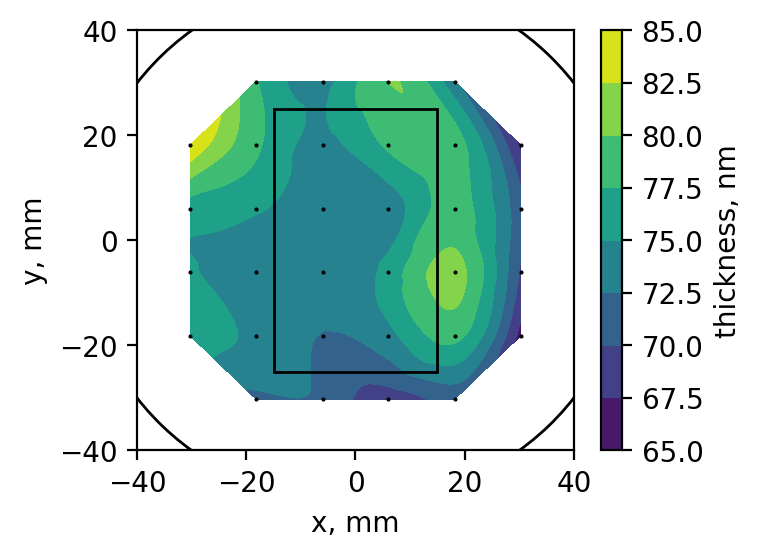

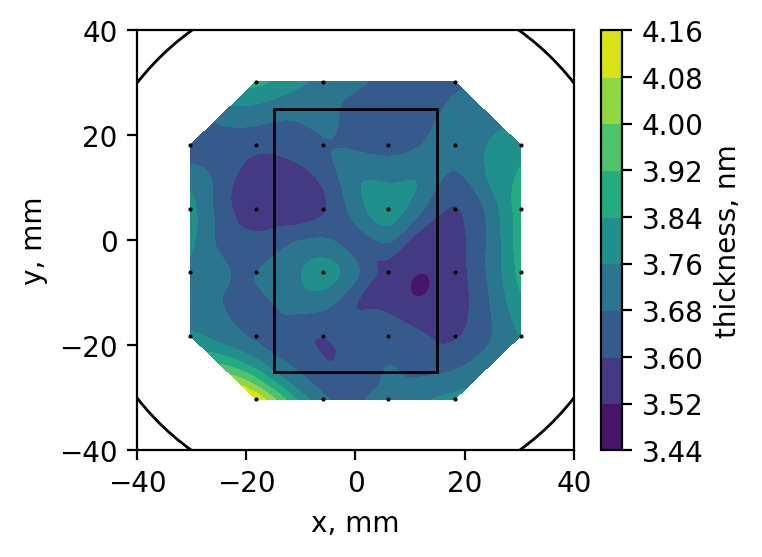

In [21]:
for name, df in outputs.items():
    fig, ax = plt.subplots(figsize=(3.9,3), dpi=200)
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

    grid_x, grid_y = np.mgrid[-35:35:500j, -35:35:500j]

    interp_points =  np.array([grid_x, grid_y]).T
    points = np.array([df['X pos'], df['Y pos']]).T

    interpgrid = griddata(points=points, values=df['thickness'], xi=(grid_x, grid_y), method='cubic')
    
    cntr = ax.contourf(grid_x, grid_y, interpgrid)
    cbar = fig.colorbar(cntr, ax=ax)

    ax.scatter(df['X pos'], df['Y pos'], color='k', marker='.',s=1)

    radius=50
    circ = plt.Circle((0, 0), radius=radius, zorder=10, facecolor=[1,1,1,0], edgecolor='k')
    ax.add_artist(circ)

    rec = plt.Rectangle((-15, -25), width=30, height=50, zorder=10, facecolor=[1,1,1,0], edgecolor='k')
    ax.add_artist(rec)

    ax.set(ylabel='y, mm', xlabel='x, mm', ybound=(-40,40), xbound=(-40,40))
    cbar.set_label('thickness, nm')
